Need:


1. Audio Features
2. Lyrical Features  (emotion, bag of words tfidf)
3. Page Ranked Artist (for recommendaiton)
4. Look at similarity of songs to see where other songs ranked


In [1]:
from pymongo import MongoClient
from pprint import pprint
from typing import List
from functools import reduce
from operator import add
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse


# DB CONFIG
client = MongoClient('mongo', 27017)
db = client.music_db
COLLECTION = db['part5-hot100-songs']


def get_songs(collection):
    return list(collection.find())

def has_spotify(song):
    return song.get('spotify', {}).get('audio_features')

def has_lyrics(song):
    if not song.get('lyrics'):
        return False
    
    if song.get('lyrics') == 'null':
        return False

    if song.get('lyrics').get('error'):
        return False
    
    if not song.get('tokens'):
        return False

    return True


SONGS = get_songs(COLLECTION)
songs = list(filter(has_lyrics, filter(has_spotify, SONGS)))

(168, 80)

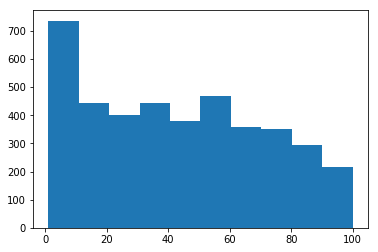

In [2]:
pos = [song['peakPos'] for song in songs]
plt.hist(pos)

from collections import Counter
Counter(pos)[1], Counter(pos)[2]

In [3]:
import numpy as np
import pandas as pd
import copy
pd.options.display.max_columns = None

def to_df(songs):
    df = pd.DataFrame(songs)
    df = df.drop(columns=['_id', 'id', 'identifier', 'lyrics', 'genre', 'isNew', 'lastPos', 'rank', 'weeks', 'track_href', 'type', 'uri', 'spotify', 'analysis_url'])
    df['lyrics_length'] = df['raw_lyrics'].apply(lambda lyrics: len("".join(lyrics.split('\n'))))
    return df
    
df = to_df(songs)
#df.head()

In [4]:
y = pd.DataFrame(df['peakPos'])
X = df.drop(['peakPos', 'artist', 'raw_lyrics', 'title', 'tokens'], axis=1)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_lyrics(songs):
    lyrics_list = [" ".join(song['tokens']) for song in songs]
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics_list)
    tfidf_array = tfidf_matrix.toarray()
    
    for vector, song in zip(tfidf_array, songs):
        song['tfidf'] = vector
    
    return tfidf_matrix
    
def vectorize_df_lyrics(df):
    lyrics_df = df['tokens'].apply(" ".join).values
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics_df)    
    return tfidf_matrix.toarray()
    
tfidf_matrix = vectorize_lyrics(songs)

In [6]:
from sklearn.metrics import pairwise_distances

distances = pairwise_distances(tfidf_matrix, metric="cosine")

In [7]:
from sklearn.model_selection import train_test_split  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)  
y_true = y_test.values.reshape(-1)

In [8]:
def tfidf_index(indexes, tfidf_matrix):
    return np.vstack([tfidf_matrix[index].toarray() for index in indexes])

def distance_index(indexes, distances):
    return np.vstack([distances[index] for index in indexes])


tfidf_mat_X_train = tfidf_index(X_train.index.values, tfidf_matrix)
tfidf_mat_X_test = tfidf_index(X_test.index.values, tfidf_matrix)

distance_X_train = distance_index(X_train.index.values, distances)
distance_X_test = distance_index(X_test.index.values, distances)

In [9]:
print(type(tfidf_mat_X_train), tfidf_mat_X_train.shape)  # 5572 doc, tfidf 100 dimension

<class 'numpy.ndarray'> (3473, 17830)


In [10]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

In [11]:
X_train[0]

array([-0.11375098,  0.63652416,  0.85934264, -0.13936446, -1.06835671,
        1.35449463, -0.74294593,  0.16278586, -1.59836149, -0.34610072,
       -0.79555568,  0.14000636, -0.07423613, -0.48212463])

In [12]:
len(tfidf_mat_X_train[0]) + len(X_train[0]) + len(distances[0])

21930

In [13]:
import copy

def combine_features(tfidf_matrix_train, distances, train_features):
    combined_matrix = []
    for tfidf, distance, features in zip(tfidf_matrix_train, distances, train_features):
        combined = np.hstack([tfidf, features])  #features, tfidf, distance, 
        combined_matrix.append(combined)
    return np.vstack(combined_matrix)

_combined_X_train = combine_features(tfidf_mat_X_train, distance_X_train, X_train)
_combined_X_test = combine_features(tfidf_mat_X_test, distance_X_test, X_test)

In [14]:
combined_X_train = _combined_X_train
combined_X_test = _combined_X_test

In [15]:
combined_X_train[0].shape

(17844,)

In [16]:
# Fit regression model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error


import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred):
    x, y = [], []
    for true, pred in zip(y_true, y_pred):
        diff = abs(true - pred)
        
    length = len(y_true)
    plt.plot(y_true, 'bo')
    plt.plot(y_pred, 'ro')
    
    
def plot_sorted_predictions(y_true, y_pred):
    true, pred = zip(*sorted(zip(y_true, y_pred)))
    plt.plot(true, pred, 'bo')


def run_model(model, train=False):

    model.fit(X_train, y_train.values.reshape(-1))
    # Predict
    y_pred = model.predict(X_test)
    y_pred = [min(pred, 100) for pred in y_pred]
    print("Error:", mse(y_true, y_pred))
    plt.figure(figsize=(20,10))
    plot_sorted_predictions(y_true, y_pred)
    return y_pred


from collections import defaultdict

def find_avg_guess_per_rank(y_true, y_pred):
    buckets = defaultdict(lambda: [])
    for true, pred in zip(y_true, y_pred):
        buckets[true].append(pred)
    return buckets


def plot_avg_guesses(y_true, y_pred):
    guesses = find_avg_guess_per_rank(y_true, y_pred)
    plt.plot(sorted(guesses.keys()), [np.mean(guesses[i]) for i in sorted(guesses.keys())])
    return guesses
    

In [25]:
# build model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D


shape = combined_X_train.shape
#input_shape=(17830,)

model = Sequential()
model.add(Dense(64, input_shape=(shape[1],)))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                1142080   
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
activation_7 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
activation_8 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
__________

In [26]:
model.fit(combined_X_train, y_train, batch_size=256, epochs=30, verbose=True, validation_split=0.1)

Train on 3125 samples, validate on 348 samples
Epoch 1/30
3125/3125 [==============================] - 1s 394us/step - loss: 2612.4693 - val_loss: 2822.1682
Epoch 2/30
3125/3125 [==============================] - 1s 278us/step - loss: 2553.9117 - val_loss: 2724.3804
Epoch 3/30
3125/3125 [==============================] - 1s 272us/step - loss: 2406.2190 - val_loss: 2474.3115
Epoch 4/30
3125/3125 [==============================] - 1s 271us/step - loss: 2083.4568 - val_loss: 1940.6011
Epoch 5/30
3125/3125 [==============================] - 1s 258us/step - loss: 1524.8076 - val_loss: 1194.8951
Epoch 6/30
3125/3125 [==============================] - 1s 266us/step - loss: 1104.7377 - val_loss: 869.9944
Epoch 7/30
3125/3125 [==============================] - 1s 266us/step - loss: 1052.6222 - val_loss: 890.6981
Epoch 8/30
3125/3125 [==============================] - 1s 269us/step - loss: 1000.7090 - val_loss: 922.8443
Epoch 9/30
3125/3125 [==============================] - 1s 256us/step - loss

Error: 874.539974108


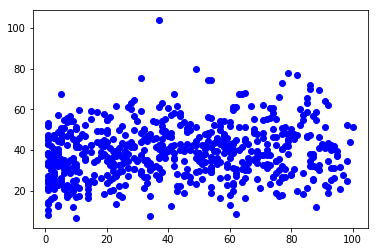

In [23]:
from sklearn.metrics import mean_squared_error as mse


y_pred = model.predict(combined_X_test).reshape(-1)
y_true = y_test.values.reshape(-1)

def print_predictions(y_pred, y_true):
    for true, pred in zip(y_true, y_pred):
        print(true, int(pred))
        

#print_predictions(y_pred, y_true)
print("Error:", mse(y_true, y_pred))
plot_sorted_predictions(y_true, y_pred)


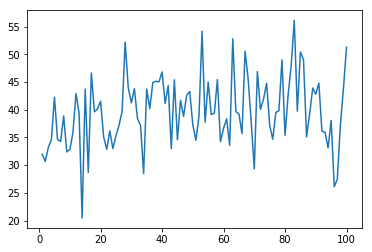

In [24]:
guesses = plot_avg_guesses(y_true, y_pred)

In [97]:
import math
from sklearn.metrics import mean_squared_error as mse

def baseline(y_test):
    mean = y_test.peakPos.values.mean()
    guesses = [mean] * len(y_test) 
    return mse(y_test, guesses)

baseline(y_train)

0.20648217183456871

Error: 0.211403047109


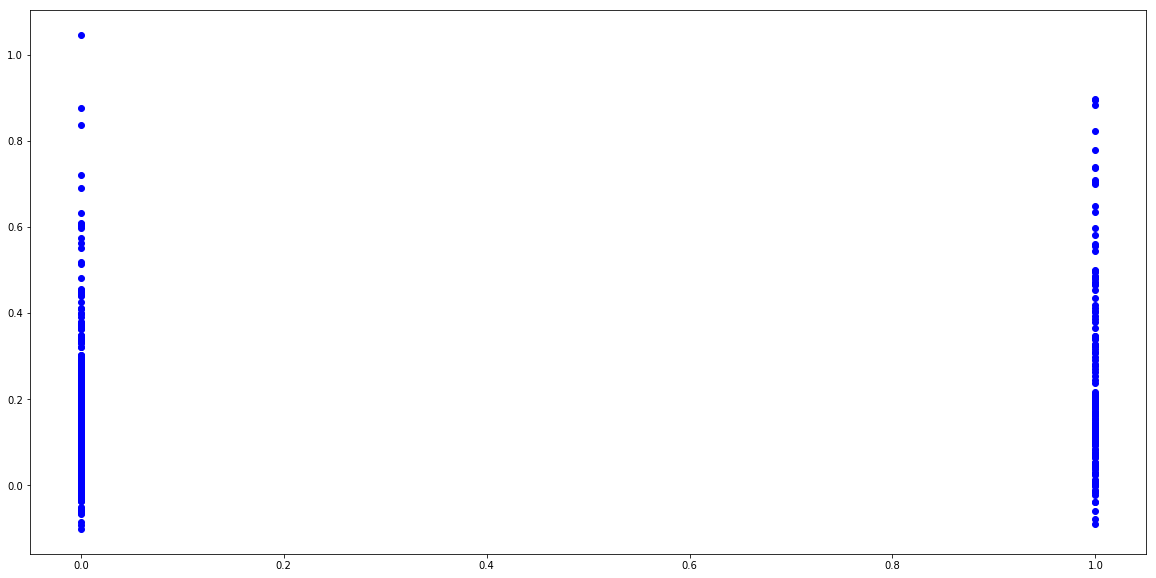

In [98]:
from sklearn.svm import SVR

model = SVR() 
y_pred = run_model(model)

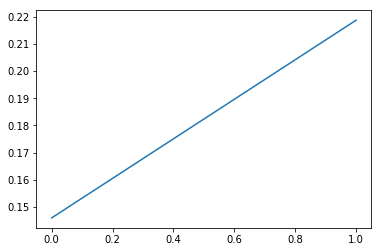

In [99]:
guesses = plot_avg_guesses(y_true, y_pred)

In [79]:
np.mean(guesses[1]), np.mean(guesses[100])

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.26216495603101642, nan)